In [1]:
suppressPackageStartupMessages({
  if (!require("logger"))
    install.packages("logger")
  library("logger")
  if (!require("data.table"))
    install.packages("data.table")
  library("data.table")
  if (!require("parallel"))
    install.packages("parallel")
  library("parallel")
  if (!require("R.utils"))
    install.packages("R.utils")
  library("R.utils")
  if (!require("primes"))
    install.packages("primes")
  library("primes")
  if (!require("utils"))
    install.packages("utils")
  library("utils")
  if (!require("rlist"))
    install.packages("rlist")
  library("rlist")
  if (!require("yaml"))
    install.packages("yaml")
  library("yaml")
  if (!require("lightgbm"))
    install.packages("lightgbm")
  library("lightgbm")
  if (!require("DiceKriging"))
    install.packages("DiceKriging")
  library("DiceKriging")
  if (!require("mlrMBO"))
    install.packages("mlrMBO")
  library("mlrMBO")
  if (!require("ggplot2"))
    install.packages("ggplot2")
  library("ggplot2")
})

In [36]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2478561,132.4,4765418,254.6,4765418,254.6
Vcells,4379488,33.5,1087757080,8299.0,1699536808,12966.5


# Clase Ternaria

In [14]:
# Genero clase ternaria
# leo el dataset
#setwd("~/buckets/b1/datasets")
dataset <- fread("../../datasets_competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "../../competencia_01.csv.gz",
    sep = ","
)

# Parámetros

In [3]:
# Parámetros
PARAM <- list()
PARAM$experimento <- "expC01_Prueba04"
PARAM$semilla_primigenia <- 200003

# training y future
PARAM$train <- c(202101, 202102)
PARAM$train_final <- c(202101, 202102)
PARAM$future <- c(202104)
PARAM$train_final_kaggle <- c(202101, 202102, 202103, 202104)
PARAM$entrega_kaggle <- c(202106)
PARAM$semilla_kaggle <- 314159 #Semilla para el modelo final que va a Kaggle, primeros números de pi que sean primos.
PARAM$cortes <- seq(0, 20000, by= 100)

# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos

PARAM$trainingstrategy$undersampling <- 0.5

# Parametros LightGBM

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir dart, ni pruebe random_forest
  objective= "binary", #default regression
  metric= "auc", # default "" 
  first_metric_only= FALSE, # default FALSE
  boost_from_average= TRUE, # default TRUE
  feature_pre_filter= FALSE, # default TRUE
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100, # default 1

  seed= PARAM$semilla_primigenia, # Relacionado con data_random_seed, feature_fraction_seed, entre otros 

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, # Default FALSE
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE, # default FALSE

  num_iterations= 1200, # default 100
  learning_rate= 0.02, # default 0.1
  feature_fraction= 0.5, # default 1
  num_leaves= 750, # default 31
  min_data_in_leaf= 5000 # default 20
)

# Aqui se cargan los bordes de los hiperparametros de la BO
PARAM$hypeparametertuning$hs <- makeParamSet(
    makeNumericParam("min_sum_hessian_in_leaf", lower= 0.001, upper= 0.1),
    
    makeNumericParam("lambda_l1", lower= 0.0, upper= 100.0),
    makeNumericParam("lambda_l2", lower= 0.0, upper= 100.0),
    
    
    makeIntegerParam("num_leaves", lower= 10L, upper= 2048L),
    makeIntegerParam("max_depth", lower= -1L, upper= 15),


    makeIntegerParam("num_iterations", lower= 50L, upper= 2000L),
    makeNumericParam("learning_rate", lower= 0.01, upper= 0.5),

    makeNumericParam("feature_fraction", lower= 0.1, upper= 1.0),
    makeNumericParam("bagging_fraction", lower= 0.0, upper= 1.0),
    makeIntegerParam("bagging_freq", lower= 0L, upper= 10L),
    
    makeIntegerParam("min_data_in_leaf", lower= 10L, upper= 4000L),
    makeNumericParam("min_gain_to_split", lower= 0.0, upper= 15.0)
)
PARAM$hyperparametertuning$iteraciones <- 80 # iteraciones bayesianas

# Funciones

In [3]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [4]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [5]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

# Configuración del Dataset

In [15]:
# lectura del dataset
#setwd("~/buckets/b1/datasets")
dataset <- fread("../../competencia_01.csv.gz", stringsAsFactors= TRUE)

In [16]:
# Ordenar el dataset
setkey(dataset, numero_de_cliente, foto_mes)

In [17]:
colnames(dataset)

[1] "numero_de_cliente"                   
  [2] "foto_mes"                            
  [3] "active_quarter"                      
  [4] "cliente_vip"                         
  [5] "internet"                            
  [6] "cliente_edad"                        
  [7] "cliente_antiguedad"                  
  [8] "mrentabilidad"                       
  [9] "mrentabilidad_annual"                
 [10] "mcomisiones"                         
 [11] "mactivos_margen"                     
 [12] "mpasivos_margen"                     
 [13] "cproductos"                          
 [14] "tcuentas"                            
 [15] "ccuenta_corriente"                   
 [16] "mcuenta_corriente_adicional"         
 [17] "mcuenta_corriente"                   
 [18] "ccaja_ahorro"                        
 [19] "mcaja_ahorro"                        
 [20] "mcaja_ahorro_adicional"              
 [21] "mcaja_ahorro_dolares"                
 [22] "cdescubierto_preacordado"            
 [23] "mcuentas_saldo"                      
 [24] "ctarjeta_debito"                     
 [25] "ctarjeta_debito_transacciones"       
 [26] "mautoservicio"                       
 [27] "ctarjeta_visa"                       
 [28] "ctarjeta_visa_transacciones"         
 [29] "mtarjeta_visa_consumo"               
 [30] "ctarjeta_master"                     
 [31] "ctarjeta_master_transacciones"       
 [32] "mtarjeta_master_consumo"             
 [33] "cprestamos_personales"               
 [34] "mprestamos_personales"               
 [35] "cprestamos_prendarios"               
 [36] "mprestamos_prendarios"               
 [37] "cprestamos_hipotecarios"             
 [38] "mprestamos_hipotecarios"             
 [39] "cplazo_fijo"                         
 [40] "mplazo_fijo_dolares"                 
 [41] "mplazo_fijo_pesos"                   
 [42] "cinversion1"                         
 [43] "minversion1_pesos"                   
 [44] "minversion1_dolares"                 
 [45] "cinversion2"                         
 [46] "minversion2"                         
 [47] "cseguro_vida"                        
 [48] "cseguro_auto"                        
 [49] "cseguro_vivienda"                    
 [50] "cseguro_accidentes_personales"       
 [51] "ccaja_seguridad"                     
 [52] "cpayroll_trx"                        
 [53] "mpayroll"                            
 [54] "mpayroll2"                           
 [55] "cpayroll2_trx"                       
 [56] "ccuenta_debitos_automaticos"         
 [57] "mcuenta_debitos_automaticos"         
 [58] "ctarjeta_visa_debitos_automaticos"   
 [59] "mttarjeta_visa_debitos_automaticos"  
 [60] "ctarjeta_master_debitos_automaticos" 
 [61] "mttarjeta_master_debitos_automaticos"
 [62] "cpagodeservicios"                    
 [63] "mpagodeservicios"                    
 [64] "cpagomiscuentas"                     
 [65] "mpagomiscuentas"                     
 [66] "ccajeros_propios_descuentos"         
 [67] "mcajeros_propios_descuentos"         
 [68] "ctarjeta_visa_descuentos"            
 [69] "mtarjeta_visa_descuentos"            
 [70] "ctarjeta_master_descuentos"          
 [71] "mtarjeta_master_descuentos"          
 [72] "ccomisiones_mantenimiento"           
 [73] "mcomisiones_mantenimiento"           
 [74] "ccomisiones_otras"                   
 [75] "mcomisiones_otras"                   
 [76] "cforex"                              
 [77] "cforex_buy"                          
 [78] "mforex_buy"                          
 [79] "cforex_sell"                         
 [80] "mforex_sell"                         
 [81] "ctransferencias_recibidas"           
 [82] "mtransferencias_recibidas"           
 [83] "ctransferencias_emitidas"            
 [84] "mtransferencias_emitidas"            
 [85] "cextraccion_autoservicio"            
 [86] "mextraccion_autoservicio"            
 [87] "ccheques_depositados"                
 [88] "mcheques_depositados"                
 [89] "ccheques_emitidos"                 

In [18]:
# Agrego columnas
dataset[, `:=`(
  # Suma de consumos de tarjetas
  mtarjetas_consumo = round(rowSums(.SD[, .(mtarjeta_visa_consumo, mtarjeta_master_consumo)], na.rm = TRUE), 1),
  # Suma de beneficios/descuentos
  mbeneficios = round(rowSums(.SD[, .(
    mcajeros_propios_descuentos,
    mtarjeta_visa_descuentos,
    mtarjeta_master_descuentos
  )], na.rm = TRUE), 1),
  # Suma de ingresos
  mingresos = round(rowSums(.SD[, .(mpayroll, mpayroll2, mtransferencias_recibidas)], na.rm = TRUE), 1),
  # Suma de inversiones
  minversiones = round(rowSums(.SD[, .(minversion1_pesos, minversion1_dolares, mplazo_fijo_pesos,mplazo_fijo_dolares, minversion2)], na.rm = TRUE), 1),
  # Diferencia: límite menos consumo para MasterCard
  diff_master_compra = round(Master_mlimitecompra - Master_mconsumospesos, 2),
  # Diferencia: límite menos consumo para Visa
  diff_visa_compra = round(Visa_mlimitecompra - Visa_mconsumospesos, 2)
)]

dataset[, `:=`(
  # Diferencia: consumo total menos comisiones
  diff_comisiones_consumo = round(mtarjetas_consumo - mcomisiones_mantenimiento, 2),
  # Diferencia: beneficios totales menos comisiones
  diff_comisiones_beneficios = round(mbeneficios - mcomisiones_mantenimiento, 2)
)]

# Columnas a las que se les aplicará el ranking
cols_a_rankear <- c(
  "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen",
  "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", "mcaja_ahorro_dolares",
  "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", "mprestamos_personales", "mprestamos_prendarios",
  "mprestamos_hipotecarios", "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2",
  "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", "mpagodeservicios", "mpagomiscuentas",
  "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy",
  "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos", 
  "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", "Master_mfinanciacion_limite",
  "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", "Master_madelantodolares",
  "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", 
  "Visa_msaldototal", "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares",
  "Visa_mpagado", "Visa_mpagospesos", "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo",
  "mtarjetas_consumo", "mbeneficios", "mingresos", "minversiones", "diff_master_compra", "diff_visa_compra", "diff_comisiones_consumo", "diff_comisiones_beneficios"
)

# Nombres para las nuevas columnas de ranking
nuevas_cols_rank <- paste0(cols_a_rankear, "_rank")

# Funcion para ranking con cero fijo
rank_con_cero_fijo <- function(x) {
  # Vector para guardar los resultados
  resultado <- numeric(length(x))
  
  # Índices para cada caso
  idx_pos <- which(x > 0)
  idx_neg <- which(x < 0)
  idx_cero <- which(x == 0)
  
  # 1. Ranking para valores positivos (> 0)
  if (length(idx_pos) > 0) {
    # Se divide por la cantidad de positivos para obtener el percentil (0 a 1)
    resultado[idx_pos] <- frankv(x[idx_pos], ties.method = "average") / length(idx_pos)
  }
  
  # 2. Ranking para valores negativos (< 0)
  if (length(idx_neg) > 0) {
    # Se calcula el percentil para los negativos y se multiplica por -1 (-1 a 0)
    resultado[idx_neg] <- (frankv(-x[idx_neg], ties.method = "average") / length(idx_neg)) * -1
  }
  
  # 3. Para los valores que son cero, el ranking es cero
  if (length(idx_cero) > 0) {
    resultado[idx_cero] <- 0
  }
  
  return(resultado)
}

# Aplicar la función a todas las columnas especificadas, agrupando por mes
dataset[, (nuevas_cols_rank) := lapply(.SD, rank_con_cero_fijo), by = foto_mes, .SDcols = cols_a_rankear]
# Elimino las columnas que rankee
dataset[, (cols_a_rankear) := NULL]

# Genero columnas Lags y Delta Lags de orden 1
cols_a_excluir <- c("numero_de_cliente", "foto_mes", "clase_ternaria")
cols_con_lag <- setdiff(names(dataset), cols_a_excluir)

nombres_nuevas_cols_lag <- paste0(cols_con_lag, "_lag1")
dataset[, (nombres_nuevas_cols_lag) := shift(.SD, 1, NA, "lag"), by = numero_de_cliente, .SDcols = cols_con_lag]

nombres_nuevas_cols_delta <- paste0(cols_con_lag, "_delta1")
dataset[, (nombres_nuevas_cols_delta) :=  Map(function(col, col_lag) get(col) - get(col_lag), cols_con_lag, nombres_nuevas_cols_lag)]

In [21]:
clientes_muestra <- sample(unique(dataset$numero_de_cliente), 5)

# 2. Filtrar el dataset solo para esos clientes
muestra <- dataset[numero_de_cliente %in% clientes_muestra]

# 3. Armar el vector de columnas a mostrar:
#    cada variable original junto con su lag y delta
cols_mostrar <- c("numero_de_cliente", "foto_mes",
                  as.vector(rbind(nuevas_cols_rank, 
                                  paste0(nuevas_cols_rank, "_lag1"), 
                                  paste0(nuevas_cols_rank, "_delta1"))))

# 4. Seleccionar solo esas columnas
muestra <- muestra[, ..cols_mostrar]

# 5. Mostrar una parte ordenada por cliente y mes
muestra[order(numero_de_cliente, foto_mes)]

numero_de_cliente,foto_mes,mrentabilidad_rank,mrentabilidad_rank_lag1,mrentabilidad_rank_delta1,mrentabilidad_annual_rank,mrentabilidad_annual_rank_lag1,mrentabilidad_annual_rank_delta1,mcomisiones_rank,mcomisiones_rank_lag1,⋯,diff_master_compra_rank_delta1,diff_visa_compra_rank,diff_visa_compra_rank_lag1,diff_visa_compra_rank_delta1,diff_comisiones_consumo_rank,diff_comisiones_consumo_rank_lag1,diff_comisiones_consumo_rank_delta1,diff_comisiones_beneficios_rank,diff_comisiones_beneficios_rank_lag1,diff_comisiones_beneficios_rank_delta1
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
567239189,202101,0.974451880,NA,NA,0.69884555,NA,NA,0.9974921378,NA,⋯,NA,0.8651931,NA,NA,0.96520101,NA,NA,0.00000000,NA,NA
567239189,202102,-0.429456282,0.97445188,-1.4039081616,0.69945746,0.69884555,0.0006119086,0.5104397716,0.9974921378,⋯,0.0122880191,0.8649451,0.8651931,-0.0002479501,0.94550615,0.96520101,-0.019694864,0.00000000,0.00000000,0.00000000
567239189,202103,0.935007971,-0.42945628,1.3644642530,0.79779286,0.69945746,0.0983353945,0.9920141029,0.5104397716,⋯,-0.0070261169,0.8603426,0.8649451,-0.0046025315,0.96562761,0.94550615,0.020121465,0.00000000,0.00000000,0.00000000
567239189,202104,-0.340368664,0.93500797,-1.2753766348,0.78892563,0.79779286,-0.0088672263,0.6577000239,0.9920141029,⋯,0.0256539593,0.8640648,0.8603426,0.0037222287,0.94063344,0.96562761,-0.024994169,0.00000000,0.00000000,0.00000000
567239189,202105,-0.389755435,-0.34036866,-0.0493867718,0.76366100,0.78892563,-0.0252646276,0.6749330943,0.6577000239,⋯,0.0192210929,0.8547818,0.8640648,-0.0092830248,0.96931019,0.94063344,0.028676748,0.19084257,0.00000000,0.19084257
567239189,202106,0.659534416,-0.38975544,1.0492898510,0.76678158,0.76366100,0.0031205831,0.7591470893,0.6749330943,⋯,-0.0177579692,0.8678253,0.8547818,0.0130434754,0.94634640,0.96931019,-0.022963791,0.08670168,0.19084257,-0.10414089
574053709,202101,0.280726680,NA,NA,0.49007719,NA,NA,0.6378888360,NA,⋯,NA,0.4430735,NA,NA,0.68636549,NA,NA,-0.07096671,NA,NA
574053709,202102,0.303594084,0.28072668,0.0228674043,0.33866488,0.49007719,-0.1514123090,0.3661808032,0.6378888360,⋯,0.0006338515,0.3866951,0.4430735,-0.0563784114,0.81768871,0.68636549,0.131323224,0.00000000,-0.07096671,0.07096671
574053709,202103,-0.260983088,0.30359408,-0.5645771721,0.26396447,0.33866488,-0.0747004151,0.5583368127,0.3661808032,⋯,-0.0072527574,0.4202839,0.3866951,0.0335887663,0.73735546,0.81768871,-0.080333251,0.00000000,0.00000000,0.00000000


In [44]:
# Verifica el ranking para 'mpasivos_margen' en el mes de julio de 2021
dataset[(foto_mes == 202104) & (numero_de_cliente %in% sample(unique(numero_de_cliente), 10)), .(numero_de_cliente, mpasivos_margen, mpasivos_margen_rank,Visa_mpagospesos, Visa_mpagospesos_rank)][order(-mpasivos_margen)]

numero_de_cliente,mpasivos_margen,mpasivos_margen_rank,Visa_mpagospesos,Visa_mpagospesos_rank
<int>,<dbl>,<dbl>,<dbl>,<dbl>
597522300,6332.16,0.9511120,-98317.08,-0.9255096
573811232,1205.45,0.6680338,-25764.10,-0.5372561
498535038,1130.90,0.6487532,NA,0.0000000
1468561253,652.27,0.4745965,-43233.10,-0.7263562
904703995,604.28,0.4499053,-9985.56,-0.2339161
627144981,541.26,0.4150284,-40701.04,-0.7063147
1420146357,319.86,0.2757614,-14463.59,-0.3341451
682793143,183.49,0.1741472,-8607.73,-0.2019440
607182438,145.98,0.1453419,0.00,0.0000000


In [7]:
# Selecciono los datos de training
dataset_train <- dataset[foto_mes %in% PARAM$train]

In [8]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

In [9]:
# defino los datos que forma parte del training
# aqui se hace el undersampling de los CONTINUA
# notar que para esto utilizo la SEGUNDA semilla

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train[, azar := runif(nrow(dataset_train))]
dataset_train[, training := 0L]

dataset_train[
  foto_mes %in%  PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

In [10]:
# Me quedo con los campos a ser utilizados en el entrenamiento

campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

In [11]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset_train[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train[training == 1L, clase01],
  free_raw_data= FALSE
)

nrow(dtrain)
ncol(dtrain)

[1] 163737

[1] 154

In [ ]:
setwd("~/buckets/b1/exp/")
dir.create(PARAM$experimento, showWarnings=FALSE)
setwd(paste0("~/buckets/b1/exp/",PARAM$experimento))

# Bayesian Optimization

In [12]:
# En el argumento x llegan los parmaetros de la bayesiana
#  devuelve la AUC en cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

In [ ]:
# Aqui comienza la configuracion de la Bayesian Optimization

# en este archivo quedan la evolucion binaria de la BO
dir.create("Archivos Bayesiana", showWarnings=FALSE)
kbayesiana <- paste0("./Archivos Bayesiana/bayesiana.RDATA")

funcion_optimizar <- EstimarGanancia_AUC_lightgbm # la funcion que voy a maximizar

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo

obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar, # la funcion que voy a maximizar
  minimize= FALSE, # estoy Maximizando la ganancia
  noisy= TRUE,
  par.set= PARAM$hypeparametertuning$hs, # definido al comienzo del programa
  has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
  save.on.disk.at.time= 600, # se graba cada 600 segundos
  save.file.path= kbayesiana
) # se graba cada 600 segundos

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
  ctrl,
  iters= PARAM$hyperparametertuning$iteraciones
) # cantidad de iteraciones

# defino el método estandar para la creacion de los puntos iniciales,
# los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

# establezco la funcion que busca el maximo
surr.km <- makeLearner(
  "regr.km",
  predict.type= "se",
  covtype= "matern3_2",
  control= list(trace= TRUE)
)


In [14]:
# inicio la optimizacion bayesiana, retomando si ya existe
# es la celda mas lenta de todo el notebook

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue(kbayesiana) # retomo en caso que ya exista
}

Warning message in mboContinue(kbayesiana):
"Tuning ended with term.iter. No need to continue. Simply returning stored result."


In [15]:
tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
colnames( tb_bayesiana)

[1] "min_sum_hessian_in_leaf" "learning_rate"          
 [3] "feature_fraction"        "bagging_fraction"       
 [5] "lambda_l1"               "lambda_l2"              
 [7] "min_gain_to_split"       "bagging_freq"           
 [9] "num_iterations"          "max_depth"              
[11] "num_leaves"              "min_data_in_leaf"       
[13] "y"                       "dob"                    
[15] "eol"                     "error.message"          
[17] "exec.time"               "ei"                     
[19] "error.model"             "train.time"             
[21] "prop.type"               "propose.time"           
[23] "se"                      "mean"

In [16]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter := .I]

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "./Archivos Bayesiana/BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model",
      "train.time","prop.type","propose.time","se","mean","iter")),
  with= FALSE
]


PARAM$out$lgbm$y <- tb_bayesiana[1, y]

write_yaml(PARAM, file="./Archivos Bayesiana/PARAM.yml")

print(PARAM$out$lgbm$mejores_hiperparametros)
print(PARAM$out$lgbm$y)

   min_sum_hessian_in_leaf learning_rate feature_fraction bagging_fraction
                     <num>         <num>            <num>            <num>
1:              0.05738828    0.09004927        0.7601894        0.6914764
   lambda_l1 lambda_l2 min_gain_to_split bagging_freq num_iterations max_depth
       <num>     <num>             <num>        <int>          <int>     <int>
1:  4.477845  1.223634         0.1407073            6           1164         5
   num_leaves min_data_in_leaf
        <int>            <int>
1:       1842              266
[1] 0.9336926


# Entrenamiento Mejores hiperparámetros

In [35]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[,.N,clase_ternaria]

# dejo los datos en el formato que necesita LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train[, campos_buenos, with= FALSE]),
  label= dataset_train[, clase01]
)

# Entrenamiento final
param_final <- modifyList(PARAM$lgbm$param_fijos,
  PARAM$out$lgbm$mejores_hiperparametros)

param_final

clase_ternaria,N
<fct>,<int>
CONTINUA,320372
BAJA+2,1857
BAJA+1,1453


$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average
[1] TRUE

$feature_pre_filter
[1] FALSE

$force_row_wise
[1] TRUE

$verbosity
[1] -100

$seed
[1] 200003

$max_depth
[1] 5

$min_gain_to_split
[1] 0.1407073

$min_sum_hessian_in_leaf
[1] 0.05738828

$lambda_l1
[1] 4.477845

$lambda_l2
[1] 1.223634

$max_bin
[1] 31

$bagging_fraction
[1] 0.6914764

$pos_bagging_fraction
[1] 1

$neg_bagging_fraction
[1] 1

$is_unbalance
[1] FALSE

$scale_pos_weight
[1] 1

$drop_rate
[1] 0.1

$max_drop
[1] 50

$skip_drop
[1] 0.5

$extra_trees
[1] TRUE

$num_iterations
[1] 1164

$learning_rate
[1] 0.09004927

$feature_fraction
[1] 0.7601894

$num_leaves
[1] 1842

$min_data_in_leaf
[1] 266

$bagging_freq
[1] 6

In [36]:
# este punto es muy SUTIL  y será revisado en la Clase 05

param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <-  round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

# entreno LightGBM

modelo_final <- lgb.train(
  data= dtrain_final,
  param= param_normalizado
)

# ahora imprimo la importancia de variables
tb_importancia <- as.data.table(lgb.importance(modelo_final))
archivo_importancia <- "./Archivos Bayesiana/impo.txt"

fwrite(tb_importancia,
  file= archivo_importancia,
  sep= "\t"
)

In [37]:
# grabo a disco el modelo en un formato para seres humanos ... ponele ...
lgb.save(modelo_final, "./Archivos Bayesiana/modelo.txt" )

# Validación Final

In [38]:
# aplico el modelo a los datos sin clase
dfuture <- dataset[foto_mes %in% PARAM$future]

# aplico el modelo a los datos nuevos
prediccion <- predict(
  modelo_final,
  data.matrix(dfuture[, campos_buenos, with= FALSE])
)

In [39]:
# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

In [40]:
# tabla de prediccion

tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion ]

# grabo las probabilidad del modelo
fwrite(tb_prediccion,
  file= "./Archivos Bayesiana/prediccion.txt",
  sep= "\t"
)

In [ ]:
# genero archivos con los  "envios" mejores
# suba TODOS los archivos a Kaggle

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle", showWarnings=FALSE)
resultados <- data.table()

for (envios in PARAM$cortes) {

  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marco los primeros

  archivo_kaggle <- paste0("./kaggle/", PARAM$experimento, "_", envios, ".csv")

  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
    file= archivo_kaggle,
    sep= ","
  )

  res <- realidad_evaluar( drealidad, tb_prediccion)
  resultados <- rbind(
    resultados,
    data.table(
      clientes = envios,
      ganancia_total = res$total,
      ganancia_public = res$public,
      ganancia_private = res$private
    )
  )
  

  options(scipen = 999)
  cat( "Envios=", envios, "\t",
    " TOTAL=", res$total,
    "  Public=", res$public,
    " Private=", res$private,
    "\n",
    sep= ""
  )

}

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


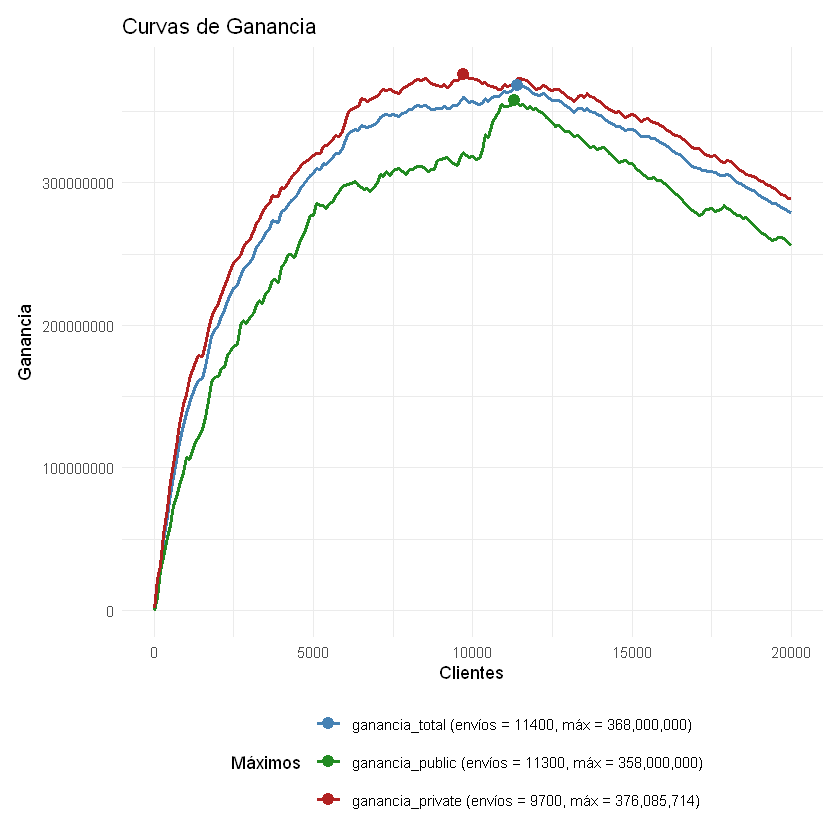

In [ ]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(linewidth = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  + ggsave("curvas.png", width = 10, height = 6)

In [31]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "sáb oct 04 19:43:44 2025"

# Ensemble

In [ ]:
# Definir las 5 semillas fijas para el ensemble
semillas <- c(200003,300007,400009,500009,600011)

# Lista vacía para ir guardando la predicción de cada modelo
lista_predicciones <- list()

# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

dataset_train <- dataset[foto_mes %in% PARAM$train_final]

# dejo los datos en el formato que necesita LightGBM
dtrain_final <- lgb.Dataset(
  data = data.matrix(dataset_train[, campos_buenos, with = FALSE]),
  label = dataset_train[, clase01]
)

# Entrenamiento final
param_final <- modifyList(PARAM$lgbm$param_fijos,
                          PARAM$out$lgbm$mejores_hiperparametros)

# este punto es muy SUTIL  y será revisado en la Clase 05
param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <- round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

# Dataset de predicción (lo definimos una sola vez fuera del bucle)
dfuture <- dataset[foto_mes %in% PARAM$future]

cat("Iniciando entrenamiento del ensamble con", length(semillas), "semillas...\n")

### Bucle para entrenar un modelo por cada semilla
for (semilla_actual in semillas) {
  print(paste0("\nEntrenando modelo con semilla: ", semilla_actual, "\n"))

  param_normalizado$seed <- semilla_actual
  
  # entreno LightGBM
  modelo_final <- lgb.train(
    data = dtrain_final,
    param = param_normalizado
  )
  
  # aplico el modelo a los datos nuevos
  prediccion_individual <- predict(
    modelo_final,
    data.matrix(dfuture[, campos_buenos, with = FALSE])
  )
  
  # Creamos una tabla con la predicción de esta semilla
  tb_prediccion_individual <- dfuture[, list(numero_de_cliente, foto_mes)] 
  tb_prediccion_individual[, prob := prediccion_individual]
  
  ### Guardamos la predicción en nuestra lista
  lista_predicciones[[as.character(semilla_actual)]] <- tb_prediccion_individual
  
} # Fin del bucle de semillas

cat("\nTodas las semillas procesadas. Creando el ensamble final...\n")

# Juntamos todas las tablas de la lista en una sola
predicciones_todas <- rbindlist(lista_predicciones)

# Agrupamos por cliente y calculamos la probabilidad promedio
tb_prediccion <- predicciones_todas[, .(prob = mean(prob)), by = .(numero_de_cliente, foto_mes)]

cat("Ensamble creado con éxito. Probabilidades promediadas.\n\n")

# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar(dfuture, PARAM)

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle_promedidado", showWarnings=FALSE)
resultados <- data.table()

for (envios in PARAM$cortes) {
  
  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marco los primeros
  
  archivo_kaggle <- paste0("./kaggle_promedidado/", PARAM$experimento, "_", envios, ".csv")
  
  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
         file = archivo_kaggle,
         sep = ","
  )
  
  res <- realidad_evaluar(drealidad, tb_prediccion)
  resultados <- rbind(
    resultados,
    data.table(
      clientes = envios,
      ganancia_total = res$total,
      ganancia_public = res$public,
      ganancia_private = res$private
    )
  )
  
  options(scipen = 999)
  cat("Envios=", envios, "\t",
      " TOTAL=", res$total,
      "  Public=", res$public,
      "  Private=", res$private,
      "\n",
      sep = ""
  )
}

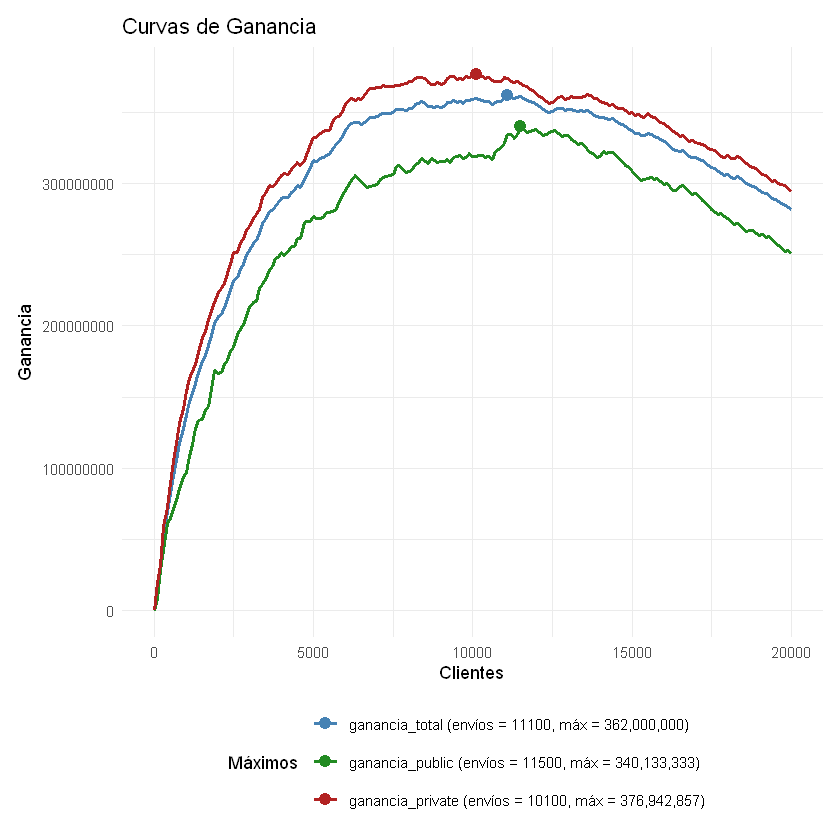

In [ ]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(linewidth  = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size  = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  + ggsave("curvas_ensamble.png", width = 10, height = 6)